### DIDしてみる

In [1]:
# (1) tidyverseとbroomの読み込み
library("tidyverse")
library("broom")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# (2) John Snowデータの読み込み
## Data from Table.12 in Snow(1855)
## http://www.ph.ucla.edu/epi/snow/table12a.html

## 1849年におけるエリア毎のコレラによる死者数
### Southwark and Vauxhall Company
sv1849 <- c(283,157,192,249,259,226,352,97,111,8,235,92)

### Lambeth Company & Southwark and Vauxhall Company
lsv1849 <- c(256,267,312,257,318,446,143,193,243,215,544,187,153,81,113,176)

## 1849年におけるエリア毎のコレラによる死者数
### Southwark and Vauxhall Company
sv1854 <- c(371, 161, 148, 362, 244, 237, 282, 59, 171, 9, 240, 174)

### Lambeth Company & Southwark and Vauxhall Company
lsv1854 <- c(113,174,270,93,210,388,92,58,117,49,193,303,142,48,165,132)

## コレラの死者数を会社ごとにまとめる
sv_death <- c(sv1849, sv1854)
lsv_death <- c(lsv1849, lsv1854)

## どのデータがどのエリアのものか
sv_area <- paste0("sv_",c(1:length(sv1849), 1:length(sv1854)))
lsv_area <- paste0("lsv_", c(1:length(lsv1849), 1:length(lsv1854)))

## どのデータがどの年のものか
sv_year <- c(rep("1849",length(sv1849)), rep("1854", length(sv1854)))
lsv_year <- c(rep("1849",length(lsv1849)), rep("1854", length(lsv1854)))

## Southwark & Vauxhallのデータフレームを作成
sv <- data.frame(area = sv_area,
                 year = sv_year,
                 death = sv_death,
                 LSV = "0",
                 company = "Southwark and Vauxhall")

## Lambeth & Southwark and Vauxhallのデータフレームを作成
lsv <- data.frame(area = lsv_area,
                  year = lsv_year,
                  death = lsv_death,
                  LSV = "1",
                  company = "Lambeth & Southwark and Vauxhall")

## 地域・年別のデータセットの作成
JS_df <- rbind(sv, lsv) %>%
  mutate(LSV =
           if_else(company == "Lambeth & Southwark and Vauxhall", 1, 0))

## 会社別のデータセットを作成
JS_sum <- JS_df %>%
  group_by(company, LSV, year) %>%
  summarise(death = sum(death))

`summarise()` has grouped output by 'company', 'LSV'. You can override using the `.groups` argument.



In [3]:
JS_sum #今回使うデータ

company,LSV,year,death
<chr>,<dbl>,<chr>,<dbl>
Lambeth & Southwark and Vauxhall,1,1849,3904
Lambeth & Southwark and Vauxhall,1,1854,2547
Southwark and Vauxhall,0,1849,2261
Southwark and Vauxhall,0,1854,2458


In [4]:
# (3) 集計と可視化による分析
## 集計による推定
JS_grp_summary <- JS_sum %>%
  mutate(year = paste("year", year, sep = "_")) %>%
  spread(year, death) %>%
  mutate(gap = year_1854 - year_1849,
         gap_rate = year_1854/year_1849 - 1)
JS_grp_summary

company,LSV,year_1849,year_1854,gap,gap_rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lambeth & Southwark and Vauxhall,1,3904,2547,-1357,-0.34759221
Southwark and Vauxhall,0,2261,2458,197,0.08712959


`gap`のgapを取ると、-1554となり、Lambeth & Southwark and Vauxhallの水源の改善により1544人感染者が減ったことがわかる。

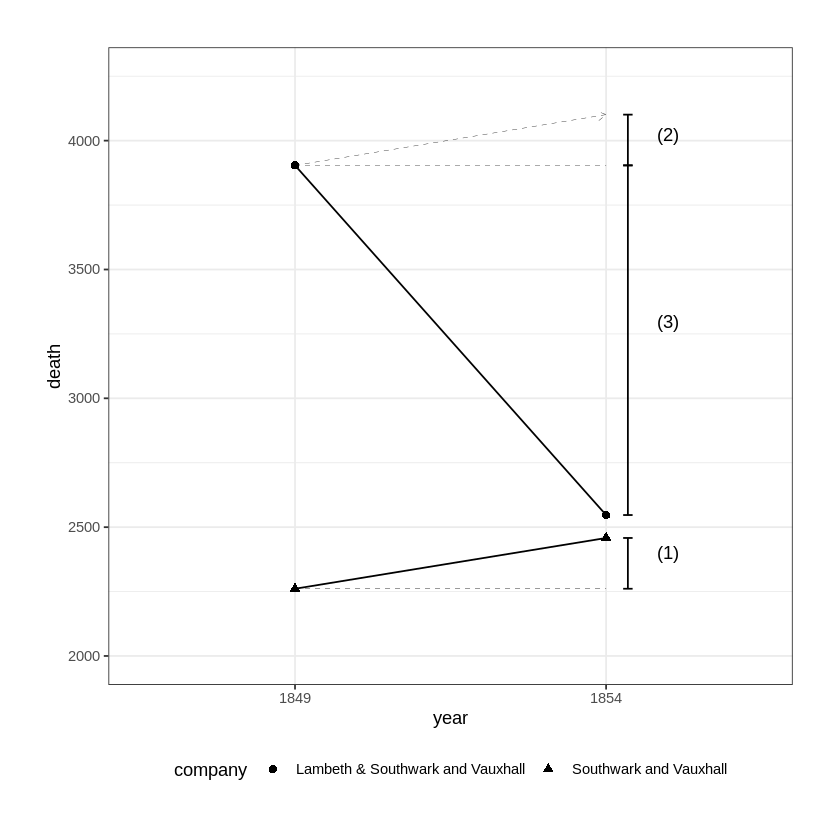

In [5]:
## ggplotによる可視化
did_plot <- JS_sum %>%
  ggplot(aes(y = death, x = year, shape = company)) +
  geom_point(size = 2) +
  geom_line(aes(group = company), linetype = 1) +
  ylim(2000, 4250) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "bottom",
        plot.margin = margin(1,1,1,1, "cm"))

## ggplotによる可視化(アノテーションを追加)
did_plot +
  annotate("text", x = 2.2, y = 2400, label = "(1)") +
  annotate("text", x = 2.2, y = 3904 + 197*0.6, label = "(2)") +
  annotate("text", x = 2.2, y = 3300, label = "(3)") +
  annotate("segment", # for common trend in treatment group
           x = 1, xend = 2,
           y = 3904, yend = 3904 + 197,
           arrow = arrow(length = unit(.2,"cm")),
           size = 0.1,
           linetype = 2) +
  annotate("segment", # for parallel trend
           x = 1, xend = 2,
           y = 2261, yend = 2261,
           size = 0.1,
           linetype = 2) +
  annotate("segment", # for parallel trend
           x = 1, xend = 2,
           y = 3904, yend = 3904,
           size = 0.1,
           linetype = 2) +
  annotate("segment", # for (1)
           x = 2.07, xend = 2.07,
           y = 2261, yend = 2458,
           arrow = arrow(ends = "both",
                         length = unit(.1,"cm"),angle = 90)) +
  annotate("segment", # for (2)
           x = 2.07, xend = 2.07,
           y = 3904, yend = 3904 + 197,
           arrow = arrow(ends = "both",
                         length = unit(.1,"cm"),angle = 90)) +
  annotate("segment", # for (3)
           x = 2.07, xend = 2.07,
           y = 3904, yend = 2547,
           arrow = arrow(ends = "both",
                         length = unit(.1,"cm"),angle = 90))

In [6]:
## 集計による推定(log)
JS_grp_summary_ln <- JS_sum %>%
  mutate(year = paste("year", year, sep = "_"),
         death = log(death)) %>%
  spread(year, death) %>%
  mutate(gap = year_1854 - year_1849)
JS_grp_summary_ln
# 背景にある再生産数的なものを抽出したいのかな？
# logを取ったあとの差分だから比率的なものが計算されるのか

company,LSV,year_1849,year_1854,gap
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Lambeth & Southwark and Vauxhall,1,8.269757,7.842671,-0.42708547
Southwark and Vauxhall,0,7.723562,7.807103,0.08354082


回帰分析を応用してDIDを行う

In [7]:
JS_sum %>%
  mutate(D1854 = if_else(year == 1854, 1, 0))
# この4サンプルを回帰することでdidみたいなことを行うことができる

company,LSV,year,death,D1854
<chr>,<dbl>,<chr>,<dbl>,<dbl>
Lambeth & Southwark and Vauxhall,1,1849,3904,0
Lambeth & Southwark and Vauxhall,1,1854,2547,1
Southwark and Vauxhall,0,1849,2261,0
Southwark and Vauxhall,0,1854,2458,1


$$death =  \beta_0 + \beta_1 LSV +  \beta_2 D1854 +  \beta_3 D1854 * LSV$$
で4サンプルを表現できる。

* $\beta_0$にはすべてが0の場合、つまりSouthwark and Vauxhall社かつ、1849年のときの感染者数が現れる。
* $\beta_1$には、1849年における、Lambeth & Southwark and Vauxhall社とSouthwark and Vauxhall社の差が現れる。
* $\beta_2$には、Southwark and Vauxhall社における、1845→1854年の感染者数の変化が現れる。
* $\beta_3$には、DIDによってもとめた、Lambeth & Southwark and Vauxhall社の感染者数の減り方(？)と同じ物が出てくる

3次元に平行四辺形を張るイメージ

In [8]:
# (4) 回帰分析を用いたDID
## Difference in Difference
JS_did <- JS_sum %>%
  mutate(D1854 = if_else(year == 1854, 1, 0)) %>%
  lm(data = ., death ~ LSV + D1854 + D1854:LSV) %>%
  tidy()
JS_did
# これでDIDを行えるのは楽！

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2261,NaN,NaN,NaN
LSV,1643,NaN,NaN,NaN
D1854,197,NaN,NaN,NaN
LSV:D1854,-1554,NaN,NaN,NaN


In [9]:
## 時間による効果は比率として表したほうが妥当であるという議論があったので、目的変数に対数をとって比率の場合の効果量を求める
## Difference in Difference(log)
JS_did_log <- JS_sum %>%
  mutate(D1854 = if_else(year == 1854, 1, 0)) %>%
  lm(data = ., log(death) ~ LSV + D1854 + D1854:LSV) %>%
  tidy()
JS_did_log

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),7.72356247,NaN,NaN,NaN
LSV,0.54619448,NaN,NaN,NaN
D1854,0.08354082,NaN,NaN,NaN
LSV:D1854,-0.51062629,NaN,NaN,NaN


In [10]:
# エリアも説明変数に加えてみよう
## Difference in Difference(エリア単位)
JS_did_area <- JS_df %>%
  mutate(D1854 = if_else(year == 1854, 1, 0)) %>%
  lm(data = ., death ~ LSV + area + D1854 + D1854:LSV) %>%
  tidy() %>%
  filter(!str_detect(term, "area"))

## Difference in Difference(州単位、log)
JS_did_area_log <- JS_df %>%
  mutate(D1854 = if_else(year == 1854, 1, 0)) %>%
  lm(data = ., log(death) ~ LSV + area + D1854 + D1854:LSV) %>%
  tidy() %>%
  filter(!str_detect(term, "area"))

JS_did_area #各エリアで平均して100人程度感染者数が減っている となった (地域を集約していたのバイアスが除かれたイメージ)

JS_did_area_log # 率としては半分ぐらい.すごい！

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),132.79167,45.72692,2.9040148,0.007420253
LSV,94.11458,64.35598,1.4624061,0.155613541
D1854,16.41667,25.36473,0.6472241,0.523160787
LSV:D1854,-101.22917,33.55439,-3.0168681,0.005649081


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.88863746,0.2398049,20.3858917,1.629158e-17
LSV,0.49373658,0.3375010,1.4629189,1.554742e-01
D1854,0.07391884,0.1330198,0.5556979,5.831681e-01
LSV:D1854,-0.56610166,0.1759687,-3.2170585,3.453469e-03


DIDにおける標準偏差とかの話は難しくてよくわからなかった

### 大規模禁煙キャンペーンがもたらすタバコの売上への影響